<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/Amazon_Product_Category/CNN_Amazon_2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
REFERENCE :  https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb
"""

from google.colab import drive
drive.mount('/gdrive')

##The Import Section

In [0]:
import torch
import numpy as np
from sklearn import preprocessing
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import spacy
from torchtext.data import Field , Dataset , Example  
import gensim
import matplotlib.pyplot as plt
import sys
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.vocab import Vectors
import spacy
from sklearn.metrics import accuracy_score

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

##Data Pre-process Section
TODO : Factorise the code

In [0]:
#df = pd.read_csv('/content/drive/My Drive/Amazon_data/Amazon_2014_joined.csv', usecols= ['reviewText','main_cat'])
#get_pandas_df(filename)
#df.to_csv('/content/drive/My Drive/Amazon_data/cnn.csv')

In [0]:
train_df = pd.read_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated.csv') #trying with the balanced dataset

In [0]:
train_df.head()

Unnamed: 0        asin  ...                       Product_Category COUNTER
0       22815  B00002N8OE  ...  Agricultural & Construction Machinery       1
1       22817  B00002N8OE  ...  Agricultural & Construction Machinery       1
2       22819  B00002N8OE  ...  Agricultural & Construction Machinery       1
3       22821  B00002N8OE  ...  Agricultural & Construction Machinery       1
4       22823  B00002N8OE  ...  Agricultural & Construction Machinery       1

[5 rows x 8 columns]

In [0]:
train_df.category.iloc[238810] #Just checking some stuff

"['Patio, Lawn & Garden', 'Gardening & Lawn Care', 'Indoor Gardening & Hydroponics', 'Germination Kits']"

In [0]:
print(train_df.columns)
# train_df = train_df.drop(columns = 'Unnamed: 0')
print(train_df.columns)
train_df.reviewText.iloc[56]
train_df['main_cat'].iloc[5]
train_df = train_df.sample(135000)

Index(['Unnamed: 0', 'asin', 'reviewText', 'summary', 'category', 'main_cat',
       'Product_Category', 'COUNTER'],
      dtype='object')
Index(['Unnamed: 0', 'asin', 'reviewText', 'summary', 'category', 'main_cat',
       'Product_Category', 'COUNTER'],
      dtype='object')


In [0]:
#In the small sample data that we have (50k), just checking how many labels we have
train_df['COUNTER'] = 1
group_data = train_df.groupby(['Product_Category'])['COUNTER'].sum()
group_data = pd.DataFrame(data = group_data)
group_data

COUNTER
Product_Category                               
Agricultural & Construction Machinery       712
Backyard Birding & Wildlife                5084
Canopies, Gazebos & Pergolas               1389
Chimes                                      927
Cleaning Tools & Chemicals                 4160
Decorative Fences                           351
Decorative Garden Stakes                    274
Doormats                                   2022
Filters & Filter Media                     1225
Fire Pits & Outdoor Fireplaces              661
Flagpole Hardware                           589
Flags                                      4922
Fountains                                   469
Garden Sculptures & Statues                3797
Gloves & Protective Gear                    834
Hammocks, Stands & Accessories             1603
Hand Tools                                 4320
Indoor Gardening & Hydroponics             2559
Mailbox Covers                              135
Other                                     26229
Outdoor Cooking Replacement Parts          1578
Outdoor Cooking Tools & Accessories        8878
Outdoor Holiday Decorations                 473
Parts & Accessories                        3198
Patio Furniture Sets                        696
Patio Seating                              3022
Plant Support Structures                   1095
Plants, Seeds & Bulbs                      7409
Plaques & Wall Art                          101
Pots, Planters & Container Accessories     4155
Pumps                                       419
Repellents                                 5255
Replacement Parts & Accessories            9900
Soils, Fertilizers & Mulches               3797
Solar & Wind Power                          841
Sprayers & Accessories                      803
Tables                                      954
Thermometers & Weather Instruments         3073
Traps                                      3701
Umbrellas & Shade                          2181
Water Gardens & Ponds                      2179
Watering Equipment                         7561
Weathervanes                                 94
Weed & Moss Control                         688
Yard Signs                                  687

In [0]:
group_data.to_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_PerCatCount_ProdCatAnnotated.csv')

In [0]:
#Encoding the labels to be fed into pytorch data loader
le = preprocessing.LabelEncoder()
train_df['Product_Category_Encoded'] = le.fit_transform(train_df.Product_Category.astype(str).values)

#train_df.groupby(['main_cat_encoded']).sum() #To check the corresponding labels of the column values

In [0]:
#Code to see if the corresponding labels of the column values
train_df['COUNTER'] = 1
train_df.groupby(['Product_Category_Encoded'])['COUNTER'].sum()

Product_Category_Encoded
0       712
1      5084
2      1389
3       927
4      4160
5       351
6       274
7      2022
8      1225
9       661
10      589
11     4922
12      469
13     3797
14      834
15     1603
16     4320
17     2559
18      135
19    26229
20     1578
21     8878
22      473
23     3198
24      696
25     3022
26     1095
27     7409
28      101
29     4155
30      419
31     5255
32     9900
33     3797
34      841
35      803
36      954
37     3073
38     3701
39     2181
40     2179
41     7561
42       94
43      688
44      687
Name: COUNTER, dtype: int64

In [0]:
print(train_df['reviewText'].astype(str).map(len).mean()) #To see the average string length of the values in the reviewText column
a = train_df['reviewText'].tolist()
type(a)
#df.columns #To check if the new column is created

230.49408888888888


list

In [0]:
train_df.tail(10)

Unnamed: 0        asin  ... COUNTER Product_Category_Encoded
3833731     1583654  B002BCSX0Y  ...       1                       19
3096528     2926684  B00D5VN70G  ...       1                       31
2812652     1857326  B0043JD3IU  ...       1                       25
3466795     4913847  B002NHWD62  ...       1                        8
2087139     5092914  B00D9CL5SW  ...       1                       13
133956      3027593  B00EOVRX06  ...       1                       16
456150      3787300  B00RU28L8O  ...       1                       27
2653561     5170838  B00J5S7O8O  ...       1                       32
3714889      745506  B000LNY4C6  ...       1                       19
3928778     2150482  B005BV0DD2  ...       1                       19

[10 rows x 9 columns]

In [0]:
#train_df = pd.read_csv('/gdrive/My Drive/Amazon_data/cnn.csv')
fields =  train_df[['reviewText','Product_Category_Encoded']]
fields['Product_Category_Encoded'] = fields['Product_Category_Encoded']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
type(fields)

pandas.core.frame.DataFrame

In [0]:
fields.to_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated_TRAIN.csv')

In [0]:
train_df = pd.read_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated_TRAIN.csv')
print(train_df.shape)
train_df = train_df.drop(columns='Unnamed: 0')
print(train_df.shape)


In [0]:
fields.head()

reviewText  Product_Category_Encoded
1661720        Cylinder sits at an angle...food leaks out.                         1
683182   This planter was the perfect spot at the front...                        29
1024461  100 ft Hose - Don't waste your money.../Its th...                        41
1040741  This is a great hose nozzle.  Such an upgrade ...                        41
845382   Bought this backpack sprayer about three years...                        35

##Class-balancing Section

In [0]:
import pandas as pd
train_df = pd.read_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated.csv')

In [4]:
train_df.shape

(4447495, 8)

In [8]:
train_df.columns

Index(['Unnamed: 0', 'asin', 'reviewText', 'summary', 'category', 'main_cat',
       'Product_Category', 'COUNTER'],
      dtype='object')

In [16]:
train_df['COUNTER'] = 1
group = train_df.groupby(['Product_Category'])['COUNTER'].sum() 
group = group.sort_index
group

<bound method Series.sort_index of Product_Category
Agricultural & Construction Machinery      23381
Backyard Birding & Wildlife               167154
Canopies, Gazebos & Pergolas               44696
Chimes                                     29809
Cleaning Tools & Chemicals                130723
Decorative Fences                          11612
Decorative Garden Stakes                    8784
Doormats                                   64869
Filters & Filter Media                     41270
Fire Pits & Outdoor Fireplaces             22250
Flagpole Hardware                          20059
Flags                                     162513
Fountains                                  15188
Garden Sculptures & Statues               122651
Gloves & Protective Gear                   27210
Hammocks, Stands & Accessories             52859
Hand Tools                                140652
Indoor Gardening & Hydroponics             88454
Mailbox Covers                              4796
Other            

In [12]:
print('Minimum number of records for a category: ',min(group)) #Weathervanes
print('Maximum number of records for a category: ',max(group)) #Other

Minimum number of records for a category:  2740
Maximum number of records for a category:  859395


In [0]:
df_class_balance = train_df.groupby('Product_Category')
df_class_balance = df_class_balance.apply(lambda x: x.sample(df_class_balance.size().min()))

In [27]:
print(df_class_balance.shape)
print(df_class_balance.columns)

(123300, 5)
Index(['asin', 'reviewText', 'summary', 'category', 'Product_Category'], dtype='object')


In [26]:
df_class_balance = df_class_balance.drop(columns = ['Unnamed: 0','COUNTER','main_cat'])
df_class_balance.head()

asin  ...                       Product_Category
Product_Category                                         ...                                       
Agricultural & Construction Machinery 7744   B0094JIQB8  ...  Agricultural & Construction Machinery
                                      16458  B0038U3NEY  ...  Agricultural & Construction Machinery
                                      12302  B00NVFQUM8  ...  Agricultural & Construction Machinery
                                      10455  B00IUAYJ2M  ...  Agricultural & Construction Machinery
                                      14433  B00ZTIG2NW  ...  Agricultural & Construction Machinery

[5 rows x 5 columns]

In [0]:
df_class_balance.to_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated_CLASSBALANCED.csv')

##Data Loader Section

In [0]:
#train_df = pd.read_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated_TRAIN.csv' , usecols= ['reviewText','Product_Category_Encoded'])
import pandas as pd
train_df = pd.read_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated_TRAIN.csv')

In [0]:
train_df.head()

reviewText  Product_Category_Encoded
0        Cylinder sits at an angle...food leaks out.                         1
1  This planter was the perfect spot at the front...                        29
2  100 ft Hose - Don't waste your money.../Its th...                        41
3  This is a great hose nozzle.  Such an upgrade ...                        41
4  Bought this backpack sprayer about three years...                        35

In [0]:
train_df['COUNTER'] = 1

group_data = train_df.groupby(['Product_Category_Encoded'])['COUNTER'].sum() 
group_data#Just to check we have 45 labels

Product_Category_Encoded
0       712
1      5084
2      1389
3       927
4      4160
5       351
6       274
7      2022
8      1225
9       661
10      589
11     4922
12      469
13     3797
14      834
15     1603
16     4320
17     2559
18      135
19    26229
20     1578
21     8878
22      473
23     3198
24      696
25     3022
26     1095
27     7409
28      101
29     4155
30      419
31     5255
32     9900
33     3797
34      841
35      803
36      954
37     3073
38     3701
39     2181
40     2179
41     7561
42       94
43      688
44      687
Name: COUNTER, dtype: int64

In [0]:
train_df = train_df.drop(columns = ['Unnamed: 0'])
print(train_df.columns)
print(train_df.shape)

Index(['reviewText', 'Product_Category_Encoded'], dtype='object')
(135000, 2)


In [0]:
train_df.to_csv('/gdrive/My Drive/Amazon_data/Amazon2014_merged_ProdCatAnnotated_TRAIN.csv', index = False)

In [0]:
train_df.iloc[90]

reviewText                  Easy to assemble, easy to use. Only complaint ...
Product_Category_Encoded                                                   19
Name: 90, dtype: object

In [0]:
train_df.reviewText.iloc[34]

'Missing the 7th chakra purple is not on there makes me sad'

This is to train the BERT Embeddings on

In [0]:
train_df = pd.read_pickle('/gdrive/My Drive/Amazon_data/Amazon2014_TRAIN_pickle_data')

In [0]:
train_df.head()

reviewText  ...                              reviewText_embeddings
0        Cylinder sits at an angle...food leaks out.  ...  [0.45636892, -0.108895175, 1.5757087, 0.770319...
1  This planter was the perfect spot at the front...  ...  [-0.62166536, 0.65735614, -0.10736252, 0.14298...
2  100 ft Hose - Don't waste your money.../Its th...  ...  [-0.033367217, 1.143534, 0.4940671, 0.20670006...
3  This is a great hose nozzle.  Such an upgrade ...  ...  [-0.72224605, 0.58374685, -0.06880468, 0.26368...
4  Bought this backpack sprayer about three years...  ...  [0.05185009, 0.78614396, 0.10027937, -0.014538...

[5 rows x 5 columns]

In [0]:
train_df.to_csv('/gdrive/My Drive/Amazon_data/Amazon2014_TRAIN_BERTEmbedding_data.csv', index=False)

Run the below lines ONLY

In [0]:
%rm-rf '/content/CNN-train'

In [0]:
 #THIS IS IMPORTATNT
"""
Reference: https://torchtext.readthedocs.io/en/latest/data.html

"""
from torchtext import data
TEXT = data.Field(tokenize = 'spacy', lower= True, batch_first = True)
#LABEL = data.LabelField()#(dtype = torch.float)
LABEL = data.LabelField()
#train_size = int(0.8 * len(train_df))
#test_size = len(train_df) - train_size
#train_dataset, test_dataset = torch.utils.data.random_split(train_df, [train_size, test_size])

In [0]:
"""
Reference : https://readthedocs.org/projects/torchtext/downloads/pdf/latest/

"""

from torchtext import data
from torchtext import datasets

fields = [('reviewText', TEXT),('Product_Category_Encoded', LABEL)]
train_data, test_data = data.TabularDataset.splits(
                                        path = '/gdrive/My Drive/Amazon_data/',
                                        train = 'Amazon2014_merged_ProdCatAnnotated_TRAIN.csv',
                                        
                                        test = 'Amazon2014_TRAIN_BERTEmbedding_data.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True #Earlier it was set to False
)

train_data, test_data = train_data.split(split_ratio=0.8,random_state = random.seed(SEED))
#Corrected the split and the columns. Earlier it was taking the Unnamed:0 colummn as the Product Category and Review Text as the Product_label which rendered the code useless.

In [0]:
train_data.reviewText_embeddings

<generator object Dataset.__getattr__ at 0x7fccbf58d4c0>

In [0]:
def make_weights_for_balanced_classes(reviews, nclasses):                        
    count = [0] * nclasses  
                                                        
    for item in reviews:  
        # print(item) 
        count = sum(1 for item in reviews)    
        # item += 1                                                  
        # count[item] += 1
    return count                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(reviews)                                              
    for idx, val in enumerate(reviews):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight       

In [0]:
args = argparse.ArgumentParser()

In [0]:
batch_size = 16

In [0]:
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(train_data.reviewText , 45)                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,                              
                                                             sampler = sampler, num_workers=0, pin_memory=True)     

In [0]:
validation_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,sampler = sampler, num_workers = 0,pin_memory=True)

In [0]:
print(f"Number of training examples: {len(train_data)}")
#print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 108000
Number of testing examples: 27000


In [0]:
print(vars(train_data[0])) #This is to check if the values in the Label and Review Text are the way we want

{'reviewText_embeddings': ['we', 'ordered', 'two', 'boxes-12', 'bulbs', 'all', 'together', ' ', ',', 'in', 'one', 'box', 'of', 'six', 'two', 'arrived', 'broken', ',', 'and', 'one', 'in', 'the', 'other', '6', 'pack', ',', 'the', 'other', 'ten', 'all', 'look', 'like', 'they', 'are', 'used', 'each', 'one', 'had', 'black', 'where', 'you', 'screw', 'in', 'socket', ',', 'should', 'be', 'clear', 'if', 'new', '!', '!', '!', '!', '.black', 'means', 'they', 'have', 'been', 'used', ',', 'so', 'we', 'have', 'had', 'to', 'switch', 'brands', 'and', 'lost', 'our', 'money', 'spent', 'on', 'these'], 'Product_Category_Encoded': '17'}


In [0]:
print(vars(test_data[1]))

{'reviewText': ['just', 'received', 'our', 'cart', 'this', 'week', '.', 'i', 'had', 'it', 'assembled', 'in', 'less', 'than', 'a', 'half', 'hour', '.', 'i', 'give', 'this', 'cart', 'four', 'stars', 'for', 'now', '.', 'if', 'it', 'holds', 'up', 'as', 'i', 'expect', 'it', 'to', ',', 'i', 'will', 'change', 'it', 'to', 'five', 'stars', '.', 'sides', 'fold', 'down', 'to', 'accommodate', 'larger', 'loads', '.', 'rolls', 'easily', 'and', 'padded', 'handle', 'is', 'comfortable', '.', 'my', 'wife', 'loves', 'it', ',', 'as', 'it', 'is', 'much', 'easier', 'to', 'move', 'larger', 'loads', '.', 'despite', 'being', 'made', 'in', 'china', ',', 'i', 'am', 'quite', 'satisfied', 'at', 'this', 'point', 'with', 'our', 'cart', '.', 'super', 'saver', 'shipping', 'made', 'this', 'an', 'even', 'better', 'deal', '.', 'thanks', 'amazon', '.'], 'Product_Category_Encoded': '19'}


Build the vocab and load the pre-trained word embeddings.

In [0]:
type(train_data)

torchtext.data.dataset.Dataset

In [0]:
%cd /content

/content


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-30 19:25:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-30 19:25:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-30 19:25:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
TEXT.build_vocab(train_data, 
                 #max_size = 25_000, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

100%|█████████▉| 398597/400000 [00:16<00:00, 25635.71it/s]

In [0]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f0bb00e7b70>, {'19': 0, '32': 1, '21': 2, '41': 3, '27': 4, '31': 5, '1': 6, '11': 7, '16': 8, '29': 9, '4': 10, '33': 11, '13': 12, '38': 13, '23': 14, '37': 15, '25': 16, '17': 17, '39': 18, '40': 19, '7': 20, '15': 21, '20': 22, '2': 23, '8': 24, '26': 25, '3': 26, '36': 27, '34': 28, '14': 29, '35': 30, '24': 31, '0': 32, '43': 33, '44': 34, '9': 35, '10': 36, '22': 37, '12': 38, '30': 39, '5': 40, '6': 41, '18': 42, '28': 43, '42': 44})


In [0]:
print(TEXT.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f0bb00e7b70>, {'<unk>': 0, '<pad>': 1, '.': 2, 'the': 3, 'i': 4, 'it': 5, 'and': 6, ',': 7, 'to': 8, 'a': 9, ' ': 10, 'this': 11, 'of': 12, 'is': 13, 'for': 14, 'in': 15, '!': 16, 'my': 17, 'that': 18, 'on': 19, 'was': 20, 'have': 21, 'with': 22, 'not': 23, 'but': 24, 'you': 25, "n't": 26, 'as': 27, 'so': 28, '-': 29, 'very': 30, 'great': 31, 'they': 32, 'are': 33, 'one': 34, 'be': 35, 'up': 36, "'s": 37, 'had': 38, 'we': 39, 'well': 40, 'do': 41, 'will': 42, 'just': 43, 'would': 44, 'out': 45, 'good': 46, 'use': 47, 'at': 48, 'product': 49, 'all': 50, 'them': 51, 'these': 52, '"': 53, 'from': 54, 'like': 55, 'if': 56, '\n\n': 57, 'or': 58, 'when': 59, ')': 60, 'did': 61, 'no': 62, 'works': 63, 'get': 64, '(': 65, 'easy': 66, 'than': 67, '\n': 68, 'can': 69, 'time': 70, 'more': 71, 'does': 72, 'has': 73, 'only': 74, 'about': 75, 'love': 76, 'after': 77, 'what': 78, 'used': 79, 'an': 80, 'work': 81, 'were': 82, 'me': 83, 'bought': 84, 'our'

As before, we create the iterators.

In [0]:
type(train_loader)

NameError: ignored

In [0]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 16 #Changed from 64 to ensure the train and test size are in perfect batches

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data),
    sort = False, #don't sort test/validation data
    batch_size=BATCH_SIZE,
    device=device)
# train_iterator, test_iterator = train_loader, validation_loader

print('Train:')
for batch in train_iterator:
    print(batch)
    
    
print('Test:')
for batch in test_iterator:
    print(batch)
# for i, (data, target) in enumerate(trainLoader):
#     print "batch index {}, 0/1: {}/{}".format(
#         i, len(np.where(target.numpy()==0)[0]), len(np.where(target.numpy()==1)[0]))



In [0]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.bn = nn.BatchNorm1d(5)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [0]:
print(len(TEXT.vocab))
print(len(LABEL.vocab))

53048
45


In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100 #Constant, kind of
N_FILTERS = 5
FILTER_SIZES = [1,1,1]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.3
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [0]:
print(TEXT.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f0bb00e7b70>, {'<unk>': 0, '<pad>': 1, '.': 2, 'the': 3, 'i': 4, 'it': 5, 'and': 6, ',': 7, 'to': 8, 'a': 9, ' ': 10, 'this': 11, 'of': 12, 'is': 13, 'for': 14, 'in': 15, '!': 16, 'my': 17, 'that': 18, 'on': 19, 'was': 20, 'have': 21, 'with': 22, 'not': 23, 'but': 24, 'you': 25, "n't": 26, 'as': 27, 'so': 28, '-': 29, 'very': 30, 'great': 31, 'they': 32, 'are': 33, 'one': 34, 'be': 35, 'up': 36, "'s": 37, 'had': 38, 'we': 39, 'well': 40, 'do': 41, 'will': 42, 'just': 43, 'would': 44, 'out': 45, 'good': 46, 'use': 47, 'at': 48, 'product': 49, 'all': 50, 'them': 51, 'these': 52, '"': 53, 'from': 54, 'like': 55, 'if': 56, '\n\n': 57, 'or': 58, 'when': 59, ')': 60, 'did': 61, 'no': 62, 'works': 63, 'get': 64, '(': 65, 'easy': 66, 'than': 67, '\n': 68, 'can': 69, 'time': 70, 'more': 71, 'does': 72, 'has': 73, 'only': 74, 'about': 75, 'love': 76, 'after': 77, 'what': 78, 'used': 79, 'an': 80, 'work': 81, 'were': 82, 'me': 83, 'bought': 84, 'our'

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,307,045 trainable parameters


In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['plain']] #This is to check if the GloVe Embeddings work

tensor([-0.8391,  0.3957,  0.8284,  0.3097, -0.2628,  0.8126,  0.0537,  0.5728,
        -0.0263,  0.2457, -0.1258,  0.0652, -0.2415,  0.1667,  0.3566,  0.1323,
         0.4286, -0.7122, -0.1416, -0.0701, -0.0372,  1.0453,  0.0192, -0.8540,
        -0.1632,  0.0275,  0.1417, -0.3992, -0.4550, -0.2401,  0.4660, -0.0205,
         0.3650, -1.1407,  0.3504,  0.0090, -0.2073,  0.4492,  0.7735, -0.2145,
         0.0359, -0.6273, -0.2567, -0.2298, -0.0084, -0.2037,  0.4379,  0.5419,
         0.5715, -0.2178,  0.5068,  0.2743,  0.7666,  0.4814, -0.8929, -1.2191,
         0.3133,  0.0192,  1.0696, -0.7353,  0.1275,  0.5389, -0.3850, -0.4339,
         0.6776, -0.3906,  0.7455,  0.0991, -0.1609, -0.4754, -0.3335, -0.0634,
         0.6028, -0.0738,  0.5395,  0.5387,  0.4185,  1.3029,  0.0587,  0.2540,
         0.0098,  0.2910, -0.8135,  0.0406, -0.3956, -0.0931, -0.2902, -0.3366,
         0.6858,  0.4893,  0.2428, -0.2124, -0.7833,  0.1428, -0.1615, -0.0239,
        -1.1748, -0.4215,  0.1436,  0.39

Next, we'll load the pre-trained embeddings

In [0]:
embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(embeddings) #Official Documentation can be found at https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/C%20-%20Loading%2C%20Saving%20and%20Freezing%20Embeddings.ipynb#scrollTo=69pBbk8JgV77

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 1.2038, -1.4485,  0.5068,  ..., -0.0766,  0.0169, -0.1824],
        [-0.4844, -1.8037, -0.9383,  ...,  1.5262,  0.3174, -2.0410],
        [ 0.1583,  0.7851,  1.4633,  ..., -2.0169, -2.5400,  0.5536]])

Then zero the initial weights of the unknown and padding tokens.

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]


model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

We initialize the optimizer, loss function (criterion) and place the model and criterion on the GPU (if available)

In [0]:
import torch.optim as optim
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
"""
Reference: https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss

"""

criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
model = model.to(device)
print(device)

cuda


All functions for train, accuracy and eval

In [0]:
def categorical_accuracy(preds, labels):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(labels)
    return correct.sum() / torch.FloatTensor([labels.shape[0]])

In [0]:
def train(model, iterator, optimizer,criterion):  
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
    
        optimizer.zero_grad()
        
        predictions = model(batch.reviewText)
        
        loss = criterion(predictions, batch.Product_Category_Encoded)
        
        acc = categorical_accuracy(predictions, batch.Product_Category_Encoded)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
    

In [0]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.reviewText).squeeze(1)
            #predictions = model(batch.main_cat_encoded)
            loss = criterion(predictions, batch.Product_Category_Encoded)
            
            acc = categorical_accuracy(predictions, batch.Product_Category_Encoded)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Let's define our function to tell us how long epochs take.

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs   

Finally, we train our model...

In [0]:
%pwd

'/content'

In [0]:
!pip install tf-nightly-2.0-preview
%load_ext tensorboard

     |████████████████████████████████| 95.2MB 111kB/s 
     |████████████████████████████████| 450kB 62.9MB/s 
     |████████████████████████████████| 3.8MB 54.1MB/s 
     |████████████████████████████████| 81kB 13.8MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [0]:
from torch.utils.tensorboard import SummaryWriter
counter = 0
counter = counter + 1
writer = SummaryWriter('CNN-train/'+str(counter))

In [0]:
save_model_name = "./cnn_model_epoch-{}"

In [0]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    writer.add_scalars('loss',
                       {'train':train_loss, 'test':valid_loss},
                       epoch)
    writer.add_scalars('accuracy',
                       {'train':100 * train_acc, 'test':100 * valid_acc},
                       epoch)
    torch.save(model.state_dict(),save_model_name.format(epoch)) 
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 2.658 | Train Acc: 30.46%
	 Val. Loss: 2.142 |  Val. Acc: 40.25%
Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 2.283 | Train Acc: 37.73%
	 Val. Loss: 2.021 |  Val. Acc: 43.53%
Epoch: 03 | Epoch Time: 0m 47s
	Train Loss: 2.193 | Train Acc: 39.92%
	 Val. Loss: 1.983 |  Val. Acc: 44.53%
Epoch: 04 | Epoch Time: 0m 47s
	Train Loss: 2.145 | Train Acc: 41.17%
	 Val. Loss: 1.951 |  Val. Acc: 45.59%
Epoch: 05 | Epoch Time: 0m 47s
	Train Loss: 2.118 | Train Acc: 41.93%
	 Val. Loss: 1.940 |  Val. Acc: 45.93%
Epoch: 06 | Epoch Time: 0m 49s
	Train Loss: 2.100 | Train Acc: 42.14%
	 Val. Loss: 1.934 |  Val. Acc: 46.15%
Epoch: 07 | Epoch Time: 0m 48s
	Train Loss: 2.083 | Train Acc: 42.63%
	 Val. Loss: 1.935 |  Val. Acc: 46.28%
Epoch: 08 | Epoch Time: 0m 48s
	Train Loss: 2.074 | Train Acc: 43.03%
	 Val. Loss: 1.933 |  Val. Acc: 46.39%
Epoch: 09 | Epoch Time: 0m 47s
	Train Loss: 2.062 | Train Acc: 43.22%
	 Val. Loss: 1.935 |  Val. Acc: 46.83%
Epoch: 10 | Epoch T

In [0]:
!pip install tf-nightly-2.0-preview
%load_ext tensorboard


In [0]:
! pip uninstall tensorboard
! pip install --force-reinstall tf-nightly-2.0-preview

In [0]:
#!pip install tensorboard
%load_ext tensorboard

In [0]:
%cd /content

/content


In [0]:
%tensorboard --logdir CNN-train

Reusing TensorBoard on port 6006 (pid 710), started 0:33:32 ago. (Use '!kill 710' to kill it.)

<IPython.core.display.Javascript object>

##Model Evaluation :  Accuracy, F1 Scores, Classification Report and Confusion Matrix

In [0]:
model.load_state_dict(torch.load('/content/cnn_model_epoch-18'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.941 | Test Acc: 46.57%


In [0]:
import sklearn
from sklearn import metrics
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report

In [0]:
def put_elements_to_device(a,b,device):
    return a.to(device), b.to(device)

In [0]:
correct = 0
total = 0
all_labels = []
all_predictions = []
for batch in test_iterator:
    batch.reviewText,batch.Product_Category_Encoded = put_elements_to_device(a=torch.tensor(batch.reviewText), b=batch.Product_Category_Encoded, device=device)
    predictions = model(batch.reviewText)
    _, predicted = torch.max(predictions.data, 1)
    total += batch.reviewText.size(0)
    correct += (predicted == batch.Product_Category_Encoded).sum().item()
    all_labels.append(batch.Product_Category_Encoded)
    all_predictions.append(predicted)
print('Accuracy of the network on the test samples: %d %%' % (
        100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Accuracy of the network on the test samples: 46 %


In [0]:
pred = torch.cat(all_predictions)
pred = pred.cpu().numpy()
all_lab = torch.cat(all_labels)
all_lab = all_lab.cpu().numpy()
print(pred.shape)
print(all_lab.shape)

(27000,)
(27000,)


Now, we can not solely rely on Accuracy as the metric for the classifier because of the Accuracy Paradox. A brief explanation would be that the accuracy will increase when the classifier always outputs Label 2 (assuming Binary classifier with Label 1 and Label 2) and the TP < FP. On the same grounds, in the cases where TN < FN, the accuracy will rise again if the classifier always outputs Label 1. Thus, we need F1 scores, Accuracy per class and Confusion Matrix to evaluate the model.

In [0]:
f1_score(all_lab, pred, average='micro')

0.46570370370370373

In [0]:
f1_score(all_lab, pred, average='macro')

0.32150081522287566

In [0]:
cm = confusion_matrix(all_lab, pred)

In [0]:
from pprint import pprint
pprint(cm)

array([[3847,  268,  259, ...,    0,    0,    0],
       [1031,  861,    5, ...,    0,    0,    0],
       [ 867,   18,  807, ...,    0,    0,    0],
       ...,
       [  13,    0,    0, ...,    0,    0,    0],
       [   9,    0,    0, ...,    0,    0,    0],
       [  19,    0,    0, ...,    0,    0,    0]])


In [0]:
def get_all_labels():
   labels = list(LABEL.vocab.stoi) 
   return labels

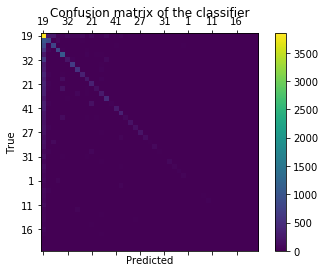

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + get_all_labels())
ax.set_yticklabels([''] + get_all_labels())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [0]:
print(classification_report(all_lab, pred))

              precision    recall  f1-score   support

           0       0.29      0.74      0.41      5179
           1       0.57      0.42      0.49      2028
           2       0.67      0.45      0.54      1774
           3       0.71      0.53      0.61      1576
           4       0.64      0.73      0.68      1457
           5       0.58      0.21      0.31      1053
           6       0.78      0.68      0.73      1020
           7       0.65      0.60      0.62       939
           8       0.67      0.41      0.50       874
           9       0.56      0.30      0.39       810
          10       0.47      0.42      0.44       828
          11       0.49      0.18      0.26       778
          12       0.45      0.36      0.40       781
          13       0.69      0.61      0.65       736
          14       0.59      0.06      0.11       613
          15       0.78      0.42      0.55       626
          16       0.60      0.56      0.58       624
          17       0.65    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###FINAL REMARKS : Clearly, we need a bigger data set to improve the accuracy of the classifier.

## User Input



In [0]:
import spacy
nlp = spacy.load('en')

def predict_class(model, sentence, min_len = 4):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [0]:
model.eval()

CNN1d(
  (embedding): Embedding(31694, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=45, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

An example review to get the predicted class

In [0]:
pred_class = predict_class(model, "I' ve used the item 2 times and the star has already sheared off. And no I did not hit anything.")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

This is to check which classes performed better

##TO-DO : AUC and ROC Curves and t-SNE

## t-SNE on the classified labels

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [0]:
results = batch.reviewText.cpu().numpy()

In [0]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000) #how to balance attention between local and global aspects of your data. The parameter is, in a sense, a guess about the number of close neighbors each point has.
tsne_results = tsne.fit_transform(results)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 8 samples in 0.000s...
[t-SNE] Computed neighbors for 8 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 8 / 8
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.311802
[t-SNE] KL divergence after 1650 iterations: 0.199309
t-SNE done! Time elapsed: 0.20628857612609863 seconds


In [0]:
for batch in train_iterator:
    label_subset = batch.Product_Category_Encoded.cpu().numpy()
    # label_subset.extend(label_subset)

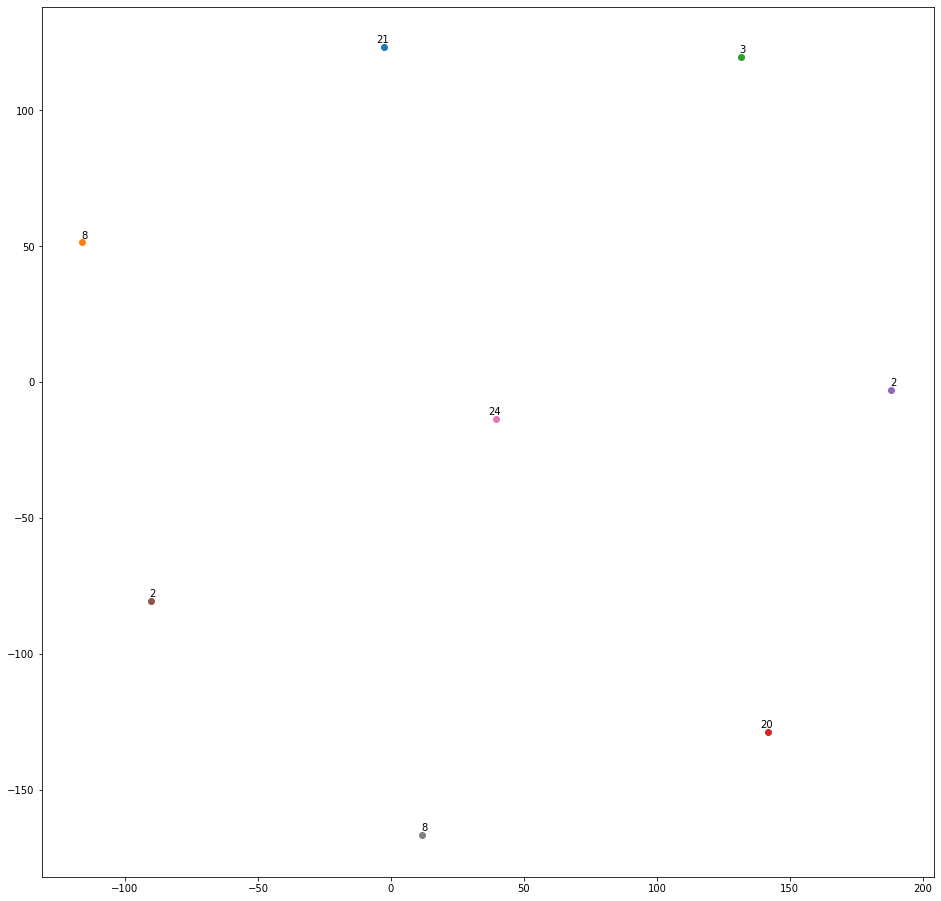

In [0]:
#And now, we plot the t-SNE
labels = []
tokens = []


x = []
y = []
for value in tsne_results:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(label_subset[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig("tsne.png", dpi = 500)
plt.show()

In [0]:
embedder = model.get_embedder()

In [0]:
X_tsne = []
y_tsne = []
with torch.no_grad():
    for batch in test_iterator:
    batch.reviewText,batch.Product_Category_Encoded = put_elements_to_device(a=torch.tensor(batch.reviewText), b=batch.Product_Category_Encoded, device=device)
    h_n, seq_embed = embedder(batch.reviewText)
    flatten_seq_embed = seq_embed.reshape(seq_embed.size(0), -1)
    X_tsne.append(flatten_seq_embed)
    y_tsne.append(batch.Product_Category_Encoded)

In [0]:
X_combined = torch.cat(X_list,0)
y_combined = torch.cat(y_list,0)

In [0]:
X = X_combined.cpu().numpy()
y = y_combined.cpu().numpy()

In [0]:
target_ids = list(range(LABEL.vocab))# binary classification

In [0]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [0]:
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

colors = sorted_names[:9 * len(target_ids): 4]
# colors

In [0]:
plt.figure(figsize=(6, 5))
for i, c in zip(target_ids, colors):
    plt.scatter(tsne_results[y == i, 0], tsne_results[y == i, 1], c=c)
plt.legend()
plt.show()
plt.savefig(fname = 't-SNE with Dropout', dpi = 600)

##Miscellaneous

In [0]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        self.bn = nn.BatchNorm2d(5)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(2)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(self.bn(conv(embedded)).squeeze(3)) for conv in self.convs]
        #x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))   
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        #cat = self.dropout(torch.cat(pooled, dim = 1))
        cat = torch.cat(pooled, dim = 1)
        #cat = [batch size, n_filters * len(filter_sizes)]
           
        return self.fc(cat)